In [1]:
from envs.connectFourEnv import ConnectFourEnv
from dqn_net_connectFour import CNNCom
from equivariant_dqn_net_connectFour import EquivariantCNNCom
from memory_connectFour import ReplayMemory
from utils.schedules import LinearSchedule
from utils.dqn_utils import evaluate, train_dqn_batch
from utils.plotting import moving_average, plot_curves

import copy
import tqdm
import torch
import numpy as np
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [15]:
params = {"num_steps": 2_500_000,
          "num_saves": 5,
          "replay_size": 200_000,
          "replay_prepopulate_steps": 50_000,
          "batch_size": 64,
          "state_size": 2,
          "gamma": 0.99,
          "model": "equi"} # equi or regular 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for run_number in [3, 4]:
    # Create environment and evaluation environment
    env = ConnectFourEnv()
    eval_env = ConnectFourEnv()
    
    # Create DQN models
    if params["model"] == "regular":
        dqn_model = CNNCom()
        dqn_target = CNNCom()
    else:
        dqn_model = EquivariantCNNCom()
        dqn_target = EquivariantCNNCom()
        dqn_model.train()
        dqn_target.train()
        
    # Create optimizer
    optimizer = torch.optim.Adam(dqn_model.parameters(), lr=1e-3)
    
    # Create epsilon function
    exploration = LinearSchedule(1.0, 0.1, 2_000_000)
        
    # Create and prepopulate memory
    memory = ReplayMemory(params["replay_size"], env.grid.shape, torch.device("cpu"))
    memory.populate(env, params["replay_prepopulate_steps"])
    
    # Create lists for tracking returns, losses, and evaluation runs
    rewards = []
    returns = []
    lengths = []
    losses = []
    evals = []
    
    # Create structures to store the models at different stages of training
    t_saves = np.linspace(0, params["num_steps"], params["num_saves"] - 1, endpoint=False)
    saved_models = {}
    
    i_episode = 0  # episode index
    t_episode = 0  # time step index (within episodes)
    
    obs = env.reset()
    G=0
    
    pbar = tqdm.trange(params["num_steps"])
    for t_total in pbar:
    
        # Save model
        if t_total in t_saves:
            model_name = f'{100 * t_total / params["num_steps"]:04.1f}'.replace('.', '_')
            saved_models[model_name] = copy.deepcopy(dqn_model)
    
        # get action using e-greedy
        eps = exploration.value(t_total)  # get current epsilon value
        if np.random.rand() < eps:
            action = np.random.choice(env.action_space)
        else:
            with torch.no_grad():
                q_values = dqn_model(torch.tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0))  # add dim to observation
                max_q_idx = torch.where(q_values == q_values.max())[0]
                action = np.random.choice(max_q_idx.tolist())
            
        # step forward env
        next_obs, reward, done = env.step(action)
    
        # add transition to memory
        memory.add(obs, action, reward, next_obs, done)
    
        if t_total%4 == 0:
            batch = memory.sample(params["batch_size"])
            loss = train_dqn_batch(optimizer, batch, dqn_model, dqn_target, params["gamma"])
            losses.append(loss)
    
        if t_total%10000 == 0:
            dqn_target.load_state_dict(dqn_model.state_dict())
    
        if t_total%1000 == 0:
            evals.append(evaluate(dqn_model, eval_env, device))
            pbar.set_description(
                f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {evals[-1]:5.2f} | Epsilon: {eps:4.2f}'
            )
    
        if done:
            rewards.append(reward)
            G = 0
            for r in rewards[::-1]:
                G = params["gamma"] * G + r
    
            returns.append(G)
            lengths.append(t_episode)
    
            # reset
            t_episode = 0
            i_episode += 1
            rewards = []
            obs = env.reset()
            
        else:
            # state = next_state
            obs = np.copy(next_obs)
            t_episode += 1
            rewards.append(reward)
    
    saved_models['100_0'] = copy.deepcopy(dqn_model)
    
    with open(f"connectfoursmarter_{params['model']}_run{run_number}.npy", "wb") as f:
        np.save(f, np.array(evals))
        np.save(f, np.array(returns))
        np.save(f, np.array(losses))
    
    def custom_dump(dqn):
        return {'state_dict': dqn.state_dict()}
    
    # checkpoint = {key: custom_dump(dqn) for key, dqn in saved_models.items()}
    # torch.save(checkpoint, f'connectfoursmarter.pt')

Episode: 259026 | Steps: 7 | Return:  9.70 | Epsilon: 0.10: 100%|█| 2500000/2500
Episode: 267484 | Steps: 5 | Return:  9.70 | Epsilon: 0.10: 100%|█| 2500000/2500


In [16]:
params = {"num_steps": 2_500_000,
          "num_saves": 5,
          "replay_size": 200_000,
          "replay_prepopulate_steps": 50_000,
          "batch_size": 64,
          "state_size": 2,
          "gamma": 0.99,
          "model": "regular"} # equi or regular 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for run_number in [3, 4]:
    # Create environment and evaluation environment
    env = ConnectFourEnv()
    eval_env = ConnectFourEnv()
    
    # Create DQN models
    if params["model"] == "regular":
        dqn_model = CNNCom()
        dqn_target = CNNCom()
    else:
        dqn_model = EquivariantCNNCom()
        dqn_target = EquivariantCNNCom()
        dqn_model.train()
        dqn_target.train()
        
    # Create optimizer
    optimizer = torch.optim.Adam(dqn_model.parameters(), lr=1e-3)
    
    # Create epsilon function
    exploration = LinearSchedule(1.0, 0.1, 2_000_000)
        
    # Create and prepopulate memory
    memory = ReplayMemory(params["replay_size"], env.grid.shape, torch.device("cpu"))
    memory.populate(env, params["replay_prepopulate_steps"])
    
    # Create lists for tracking returns, losses, and evaluation runs
    rewards = []
    returns = []
    lengths = []
    losses = []
    evals = []
    
    # Create structures to store the models at different stages of training
    t_saves = np.linspace(0, params["num_steps"], params["num_saves"] - 1, endpoint=False)
    saved_models = {}
    
    i_episode = 0  # episode index
    t_episode = 0  # time step index (within episodes)
    
    obs = env.reset()
    G=0
    
    pbar = tqdm.trange(params["num_steps"])
    for t_total in pbar:
    
        # Save model
        if t_total in t_saves:
            model_name = f'{100 * t_total / params["num_steps"]:04.1f}'.replace('.', '_')
            saved_models[model_name] = copy.deepcopy(dqn_model)
    
        # get action using e-greedy
        eps = exploration.value(t_total)  # get current epsilon value
        if np.random.rand() < eps:
            action = np.random.choice(env.action_space)
        else:
            with torch.no_grad():
                q_values = dqn_model(torch.tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0))  # add dim to observation
                max_q_idx = torch.where(q_values == q_values.max())[0]
                action = np.random.choice(max_q_idx.tolist())
            
        # step forward env
        next_obs, reward, done = env.step(action)
    
        # add transition to memory
        memory.add(obs, action, reward, next_obs, done)
    
        if t_total%4 == 0:
            batch = memory.sample(params["batch_size"])
            loss = train_dqn_batch(optimizer, batch, dqn_model, dqn_target, params["gamma"])
            losses.append(loss)
    
        if t_total%10000 == 0:
            dqn_target.load_state_dict(dqn_model.state_dict())
    
        if t_total%1000 == 0:
            evals.append(evaluate(dqn_model, eval_env, device))
            pbar.set_description(
                f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {evals[-1]:5.2f} | Epsilon: {eps:4.2f}'
            )
    
        if done:
            rewards.append(reward)
            G = 0
            for r in rewards[::-1]:
                G = params["gamma"] * G + r
    
            returns.append(G)
            lengths.append(t_episode)
    
            # reset
            t_episode = 0
            i_episode += 1
            rewards = []
            obs = env.reset()
            
        else:
            # state = next_state
            obs = np.copy(next_obs)
            t_episode += 1
            rewards.append(reward)
    
    saved_models['100_0'] = copy.deepcopy(dqn_model)
    
    with open(f"connectfoursmarter_{params['model']}_run{run_number}.npy", "wb") as f:
        np.save(f, np.array(evals))
        np.save(f, np.array(returns))
        np.save(f, np.array(losses))
    
    def custom_dump(dqn):
        return {'state_dict': dqn.state_dict()}
    
    # checkpoint = {key: custom_dump(dqn) for key, dqn in saved_models.items()}
    # torch.save(checkpoint, f'connectfoursmarter.pt')

Episode: 248837 | Steps: 4 | Return:  9.14 | Epsilon: 0.10: 100%|█| 2500000/2500
Episode: 225921 | Steps: 2 | Return:  9.14 | Epsilon: 0.10: 100%|█| 2500000/2500


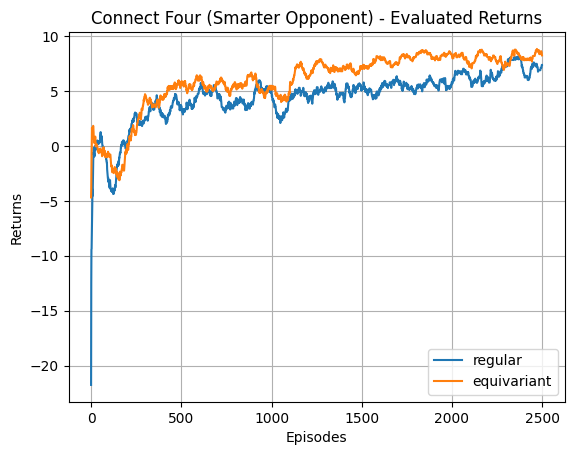

In [27]:
evals_regular = []
evals_equi = []
for run_n in [2, 3, 4]:
    with open(f"connectfoursmarter_regular_run{run_n}.npy", "rb") as f:
        evals_regular.append(np.load(f))
        returns_regular = np.load(f)
        losses_regular = np.load(f)
    
    with open(f"connectfoursmarter_equi_run{run_n}.npy", "rb") as f:
        evals_equi.append(np.load(f))
        returns_equi = np.load(f)
        losses_equi = np.load(f)
f
plt.plot(moving_average(np.array(evals_regular).mean(axis=0)), 'C0')
plt.plot(moving_average(np.array(evals_equi).mean(axis=0)), 'C1')
plt.legend(["regular", "equivariant"])
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.title("Connect Four (Smarter Opponent) - Evaluated Returns")
plt.grid()

<Figure size 640x480 with 0 Axes>

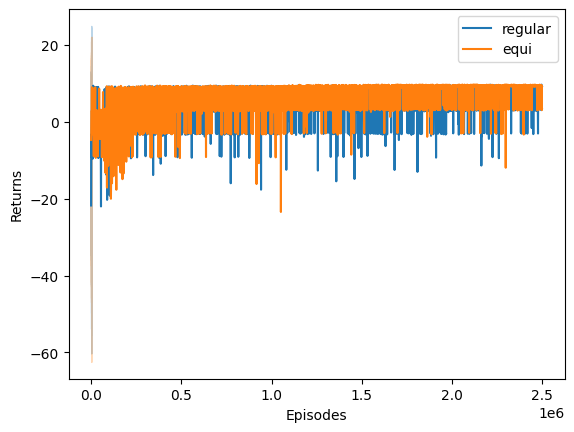

In [22]:
plot_curves([np.array(evals_regular), np.array(evals_equi)], ['regular', 'equi'], ['C0', 'C1'], 'Returns')

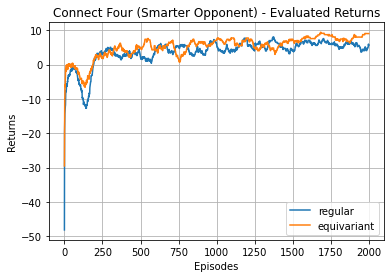

In [34]:
with open("connectfoursmarter_regular_run2.npy", "rb") as f:
    evals_regular = np.load(f)
    returns_regular = np.load(f)
    losses_regular = np.load(f)

with open("connectfoursmarter_regular_run2.npy", "rb") as f:
    evals_equi = np.load(f)
    returns_equi = np.load(f)
    losses_equi = np.load(f)

plt.plot(moving_average(evals_regular))
plt.plot(moving_average(evals_equi))
plt.legend(["regular", "equivariant"])
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.title("Connect Four (Smarter Opponent) - Evaluated Returns")
plt.grid()

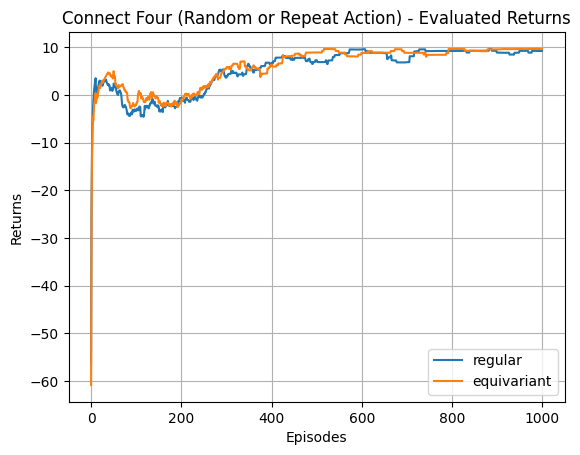

In [14]:
with open("connectfourmodified_regular_run1.npy", "rb") as f:
    evals_regular = np.load(f)
    returns_regular = np.load(f)
    losses_regular = np.load(f)

with open("connectfourmodified_equi_run1.npy", "rb") as f:
    evals_equi = np.load(f)
    returns_equi = np.load(f)
    losses_equi = np.load(f)

plt.plot(moving_average(evals_regular))
plt.plot(moving_average(evals_equi))
# plt.plot(moving_average(returns_regular))
# plt.plot(moving_average(returns_equi))
plt.legend(["regular", "equivariant"])
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.title("Connect Four (Random or Repeat Action) - Evaluated Returns")
plt.grid()

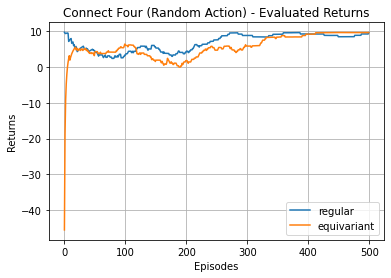

In [4]:
with open("connect4_regular_run1.npy", "rb") as f:
    evals_regular = np.load(f)
    returns_regular = np.load(f)
    losses_regular = np.load(f)

with open("connectfour_equi_run1.npy", "rb") as f:
    evals_equi = np.load(f)
    returns_equi = np.load(f)
    losses_equi = np.load(f)

plt.plot(moving_average(evals))
plt.plot(moving_average(evals_equi))
# plt.plot(moving_average(returns_regular))
# plt.plot(moving_average(returns_equi))
plt.legend(["regular", "equivariant"])
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.title("Connect Four (Random Action) - Evaluated Returns")
plt.grid()

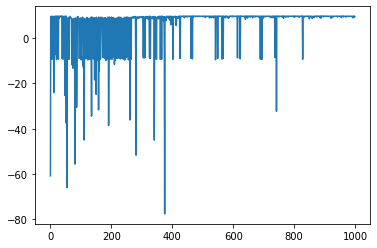

In [8]:
plt.plot(evals)

In [43]:
dqn_model(torch.tensor(env.grid, dtype=torch.float32).unsqueeze(0).unsqueeze(0))

tensor([9.7506, 9.6941, 9.7230, 9.9938, 9.8412, 9.8118, 9.8416, 9.7672, 9.7152],
       grad_fn=<SqueezeBackward0>)

In [47]:
def count_concurrent_occurrences(lst, element):
  count = 0
  max_count = 0

  for item in lst:
    if item == element:
      count += 1
      max_count = max(max_count, count)
    else:
      count = 0

  return max_count

In [49]:
count_concurrent_occurrences(env.grid[:, 3], .5)

3

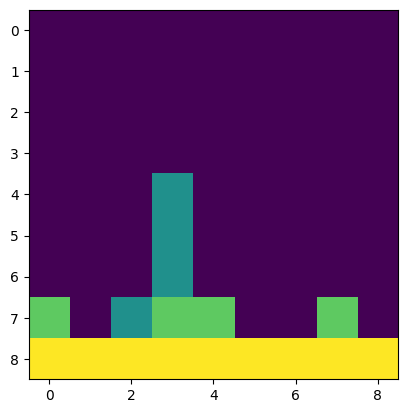

In [42]:
env.render()

In [10]:
with open(f"connectfourmodified_regular_run1.npy", "rb") as f:
    evals_regular = np.load(f)
    returns_regular = np.load(f)
    losses_regular = np.load(f)

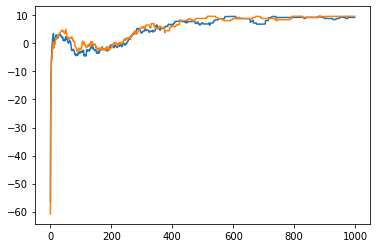

In [14]:
plt.plot(moving_average(evals_regular))
plt.plot(moving_average(evals))

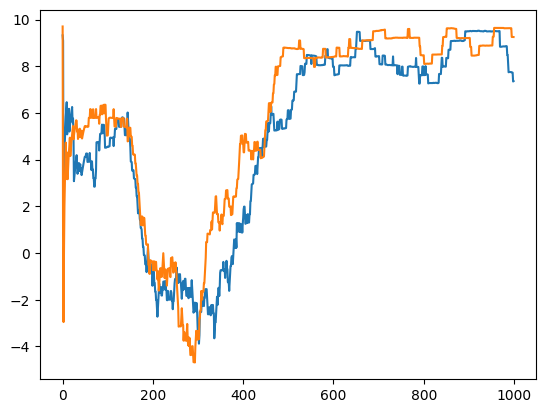

In [10]:
plt.plot(moving_average(evals))
plt.plot(moving_average(evals_regular[0]))

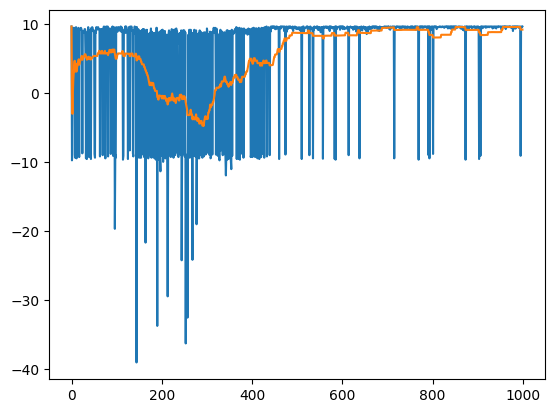

In [4]:
# THIS WAS REGULAR NOT EQUI
evals_equi = evals
plt.plot(evals_equi)
plt.plot(moving_average(evals_equi))

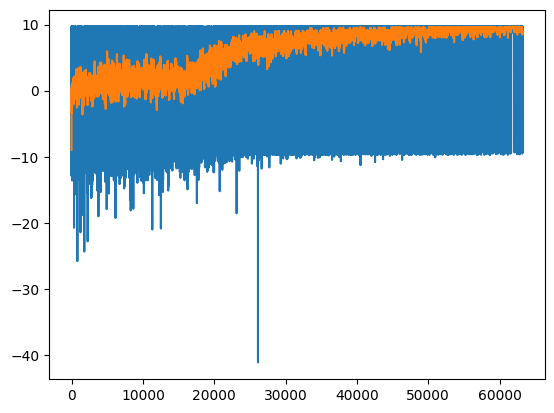

In [15]:
plt.plot(returns)
plt.plot(moving_average(returns))

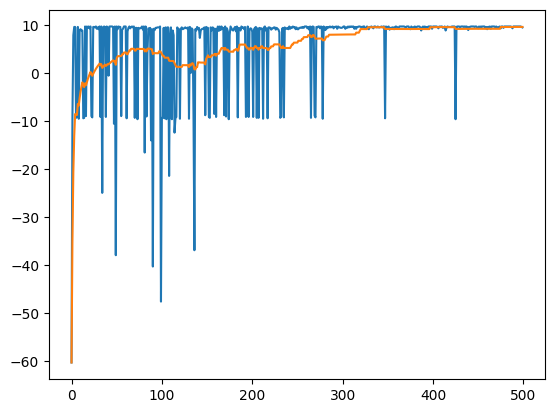

In [16]:
plt.plot(evals)
plt.plot(moving_average(evals))

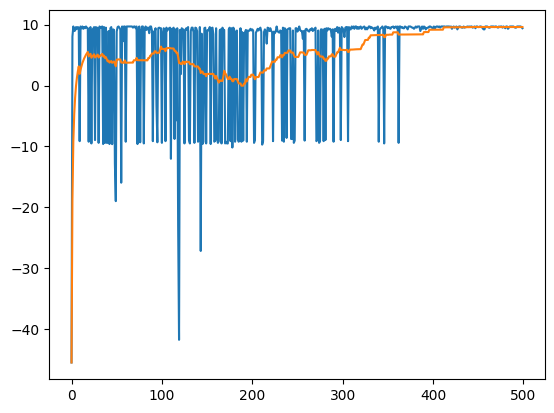

In [19]:
plt.plot(evals)
plt.plot(moving_average(evals))

In [26]:
evals = []
returns = []
loseses = []
with open(f"connectfour_regular_run1.npy", "rb") as f:
    evals.append(np.load(f))
    returns.append(np.load(f))
    loseses.append(np.load(f))
with open(f"connectfour_equi_run1.npy", "rb") as f:
    evals.append(np.load(f))
    returns.append(np.load(f))
    loseses.append(np.load(f))

In [31]:
dqn_model.r2_act

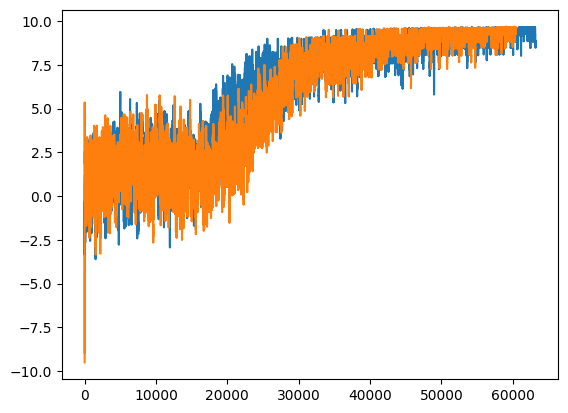

In [27]:
plt.plot(moving_average(returns[0]))
plt.plot(moving_average(returns[1]))

In [43]:
with open(f"connect4_regular_run1.npy", "wb") as f:
    np.save(f, np.array(evals))
    np.save(f, np.array(returns))
    np.save(f, np.array(losses))

In [2]:
[evaluate(dqn_model, eval_env) for _ in range(10)]

NameError: name 'dqn_model' is not defined

In [ ]:
def custom_dump(dqn):
    return {
        # 'args': (2, 9),
        # 'kwargs': {
        #     'num_layers': 3,
        #     'hidden_dim': 1,
        # },
        'state_dict': dqn.state_dict(),
    }

checkpoint = {key: custom_dump(dqn) for key, dqn in saved_models.items()}
torch.save(checkpoint, f'fourrooms_200000_to_400000_steps.pt')

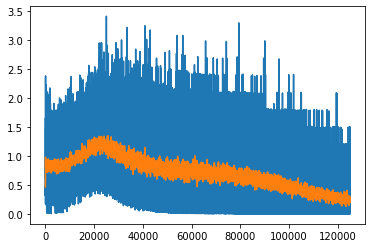

In [10]:
plt.plot(losses)
plt.plot(moving_average(losses))

In [ ]:
min_len = min([len(r) for r in returns_equi])
returns_equi = [r[:min_len] for r in returns_equi]

min_len = min([len(r) for r in returns])
returns = [r[:min_len] for r in returns]

In [ ]:
plot_curves([np.array(eval_rot), np.array(eval_rot_equi)], ['Regular DQN', 'Equivariant DQN'], ['C0', 'C1', 'C2', 'C3', 'C4'], 'Returns')

In [ ]:
plot_curves([np.array(eval_reg_equi)], 'Equivariant DQN', ['C1', 'C2', 'C3', 'C4'], 'Returns')

In [ ]:
np.argwhere(np.rot90(x, 2))[0]

In [ ]:
dqn = CNNCom()
dqn.load_state_dict(checkpoint["50_0"]["state_dict"])

In [ ]:
dqn = CNNCom()

In [ ]:
dqn(torch.tensor(env.grid, dtype=torch.float32).unsqueeze(0))[0]

In [ ]:
rewards = [-1, -1, -1, -1, -1, -1, -1, 1]
g=0
for r in rewards[::-1]:
    g = .99*g + r

In [ ]:
maze = MazeEnv(3, 123)
maze_rot = MazeEnv(3, 123, maze.grid, 1)

In [ ]:
maze_rot.grid

In [ ]:
env.step(7)
print(env.grid)
x = (dqn_model(torch.tensor(env.grid.copy(), dtype=torch.float32).unsqueeze(0).unsqueeze(0)).reshape(3, 3))
for y in x:
    print(f"{y[0]}\t{y[1]}\t{y[2]}")

In [ ]:
q_values = dqn_model(torch.tensor(env.grid, dtype=torch.float32).unsqueeze(0))  # add dim to observation
max_q_idx = torch.where(q_values == q_values.max())[0]
print((max_q_idx.tolist()))

In [ ]:
x = (dqn_model(torch.tensor(env.grid, dtype=torch.float32).unsqueeze(0)).reshape(3, 3))
for y in x:
    print(f"{y[0]}\t{y[1]}\t{y[2]}")
        

In [ ]:
checkpoint = torch.load("dim7_runs250000_4actions_equi.pt")

In [ ]:
dqn = EquivariantCNNCom()
dqn.load_state_dict(checkpoint["100_0"]["state_dict"])
maze = MazeEnv(3, 123)

In [ ]:
g = [evaluate(dqn, maze, 0.01)[0] for _ in range(20)]

In [ ]:
maze_rot = MazeEnv(3, 123, maze.grid, 1)
maze_rot.reset()

In [ ]:
g_rot = [evaluate(dqn, maze_rot, 0.01)[0] for _ in range(20)]

In [ ]:
g_rot

In [5]:
# manually evaluate equi dqn
env.reset()

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1.]])

tensor([9.5964, 9.5999, 9.6424, 9.6556, 9.7473, 9.8744, 9.8869],
       grad_fn=<SqueezeBackward0>)
[6]


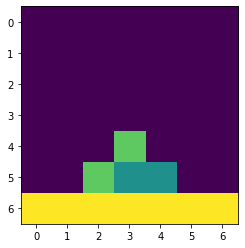

In [61]:
env.reset()
env.grid[5, 3] = 0.5
env.grid[4, 3] = 0.75
env.grid[5, 4] = 0.5
env.grid[5, 2] = 0.75
q_values = dqn_model(torch.tensor(env.grid, dtype=torch.float32).unsqueeze(0).unsqueeze(0))  # add dim to observation
print(q_values)
max_q_idx = torch.where(q_values == q_values.max())[0]
print((max_q_idx.tolist()))
env.render()

tensor([9.8869, 9.8744, 9.7473, 9.6556, 9.6424, 9.5999, 9.5964],
       grad_fn=<SqueezeBackward0>)
[0]


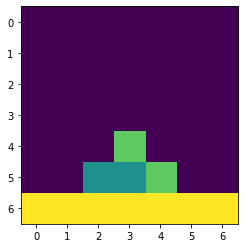

In [63]:
env.reset()
env.grid[5, 3] = 0.5
env.grid[4, 3] = 0.75
env.grid[5, 2] = 0.5
env.grid[5, 4] = 0.75
q_values = dqn_model(torch.tensor(env.grid, dtype=torch.float32).unsqueeze(0).unsqueeze(0))  # add dim to observation
print(q_values)
max_q_idx = torch.where(q_values == q_values.max())[0]
print((max_q_idx.tolist()))
env.render()

In [ ]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    # assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

plt.plot(returns)
plt.plot(moving_average(returns))

In [ ]:
g_equi = [evaluate(dqn_model, maze, 0.01, True)[0] for _ in range(20)]

In [ ]:
maze_rot.reset()
maze_rot.render()

In [ ]:
maze_rot = MazeEnv(3, 123, maze.grid, 1)
maze_rot.reset()
# g_rot_equi = [evaluate(dqn_model, maze_rot, 0.01, True)[0] for _ in range(20)]

In [ ]:
g_rot_equi

In [ ]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    # assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

plt.plot(returns)
plt.plot(moving_average(returns))